# Read stack of dm3 image files

This notebook reads a stack of **.dm3** microscopy images for analysis.

Created April 8, 2020
author: ericmuckley@gmail.com

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from skimage.transform import rescale

# set numpy random seed for reproducible results
np.random.seed(0)

# this is the library for reading the dm3 files
# install this using 'pip install ncempy'
from ncempy.io import dm

# these are custom methods in a .py file in the same directory
import microscopy_methods as mm

### Identify the image stack file and read it

In [2]:
# identify the image stack filename
stack_filename = 'stack_pure_ZrO2-24%_25%_10_pics_each_26%_after_200us_1Hz.dm3'

# get path of the image stack file if it is in the same directory
stack_path = os.path.join(os.getcwd(), stack_filename)

# try to read stack data
try:
    d = mm.read_stack(stack_path)
    
    # examine the data
    for key in d:
        print('{}: {}'.format(key, d[key]))

# if stack file does not exist
except FileNotFoundError:
    print('\n\nCANNOT FIND STACKED IMAGE FILE.')
    print('Please place it in same directory as "read_stack.ipynb"')
    print('and set the correct "stack_filename".')

filename: stack_pure_ZrO2-24%_25%_10_pics_each_26%_after_200us_1Hz.dm3
data: [[[1127 1197 1230 ... 1749 1662 1651]
  [ 996 1095 1164 ... 1703 1642 1661]
  [1134 1127 1158 ... 1741 1708 1618]
  ...
  [1565 1786 1770 ... 1676 1726 1721]
  [1688 1869 1777 ... 1764 1722 1838]
  [1707 1824 1660 ... 1717 1684 1750]]

 [[1136 1067 1289 ... 1691 1762 1698]
  [1096 1118 1231 ... 1725 1463 1549]
  [1193 1234 1206 ... 1656 1557 1513]
  ...
  [1491 1498 1473 ... 1570 1616 1491]
  [1534 1564 1524 ... 1711 1560 1491]
  [1711 1654 1567 ... 1658 1547 1483]]

 [[1570 1553 1651 ... 1602 1679 1633]
  [1815 1645 1679 ... 1653 1737 1750]
  [1781 1682 1705 ... 1722 1694 1741]
  ...
  [1796 1693 1608 ... 1449 1411 1465]
  [1792 1680 1564 ... 1604 1426 1316]
  [1604 1591 1493 ... 1616 1546 1515]]

 ...

 [[1377 1533 1604 ... 1407 1474 1680]
  [1309 1381 1454 ... 1410 1435 1597]
  [1273 1295 1311 ... 1567 1580 1556]
  ...
  [1425 1528 1531 ... 1689 1647 1635]
  [1512 1721 1587 ... 1538 1660 1677]
  [1642 1721 

### Show images in the stack

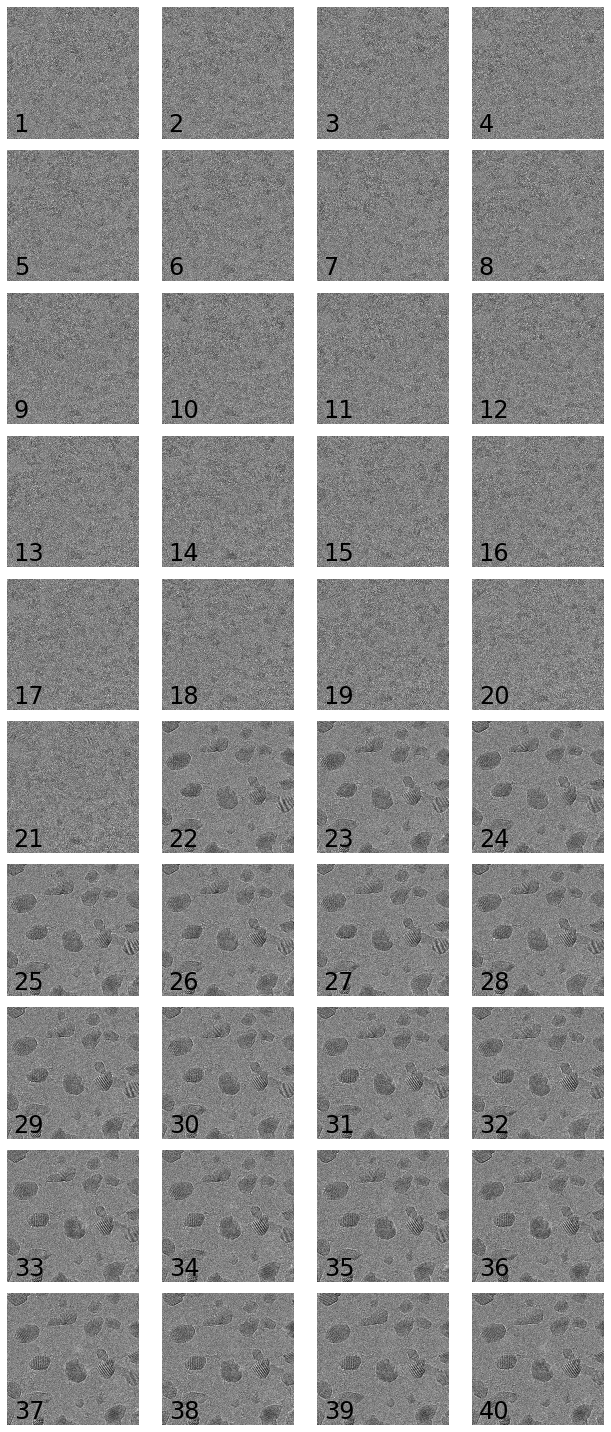

In [3]:
mm.show_image_stack(d)

### Test gaussian filtering and domain identification algorithms

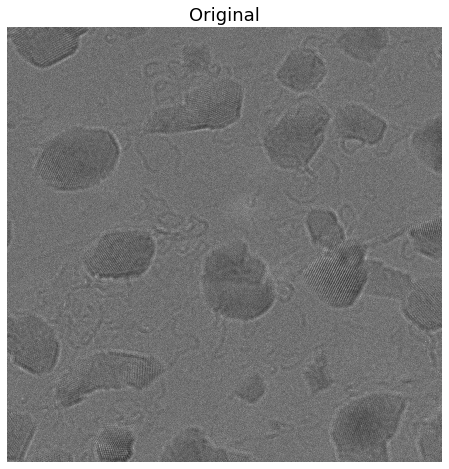

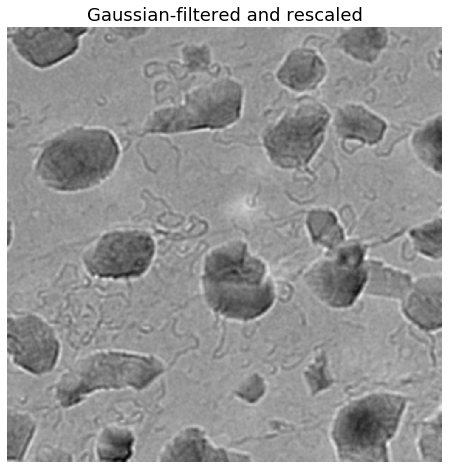

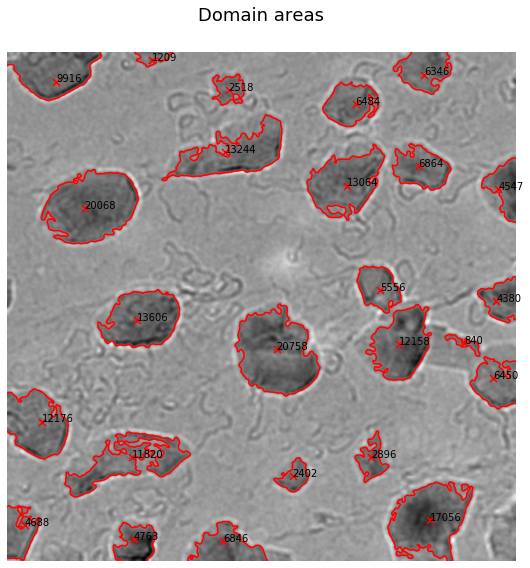

In [12]:
# show original image
img = d['data'][-1,:,:]
plt.imshow(img, cmap='gray', origin='lower')
mm.plot_setup(axes_on=False, title='Original')
plt.show()

# gaussian filter and rescale image
filt = gaussian_filter(img, sigma=5)
filt_s = rescale(filt, 0.5, mode="reflect")
plt.imshow(filt_s, cmap='gray', origin='lower')
mm.plot_setup(axes_on=False, title='Gaussian-filtered and rescaled')
plt.show()

# get crystal domain information from image
domains = mm.get_domains(filt_s, min_area=800, max_area=40000)

plt.imshow(filt_s, cmap='gray', origin='lower')
# loop over each domain and overlay it on image
for i in range(len(domains['area'])):
    # plot contour line
    plt.plot(domains['contour'][i][:,0], domains['contour'][i][:,1], c='r', linewidth=1.5)
    # show area of domain
    plt.text(domains['mean_x'][i], domains['mean_y'][i], str(round(domains['area'][i])))
    plt.scatter(domains['mean_x'][i], domains['mean_y'][i], marker='x', c='r', s=50)
mm.plot_setup(axes_on=False, title='Domain areas')
plt.show()

### Run domain anaylsis on entire image stack

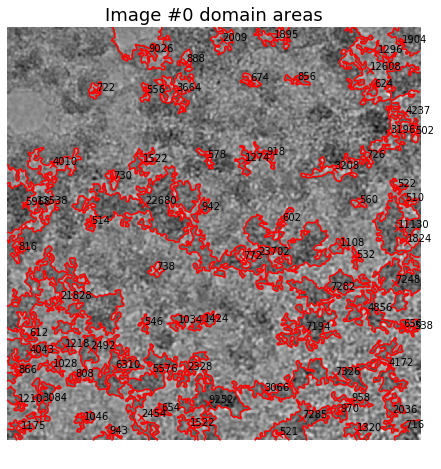

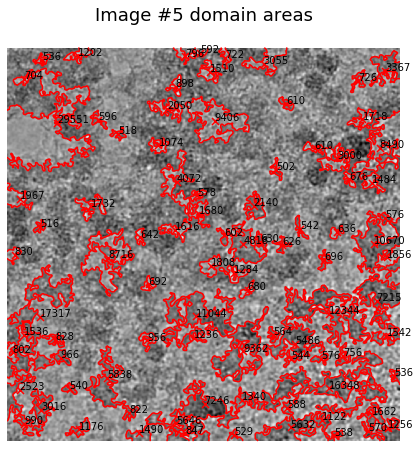

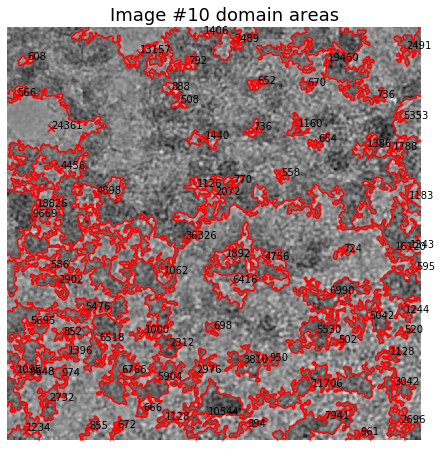

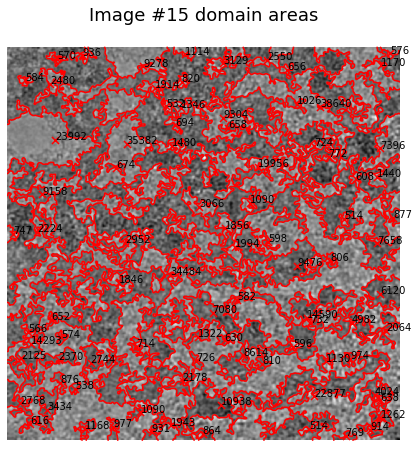

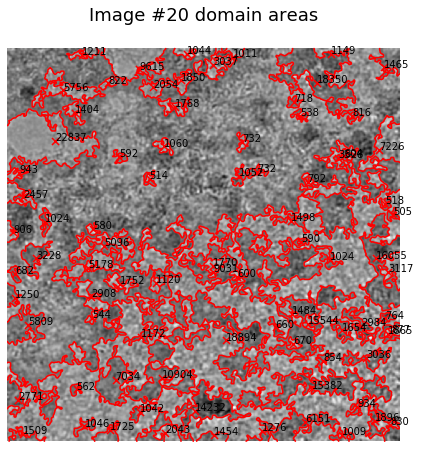

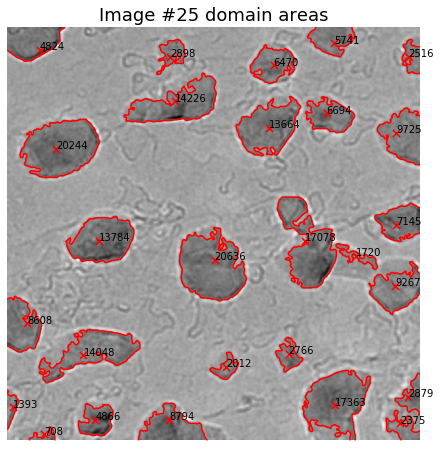

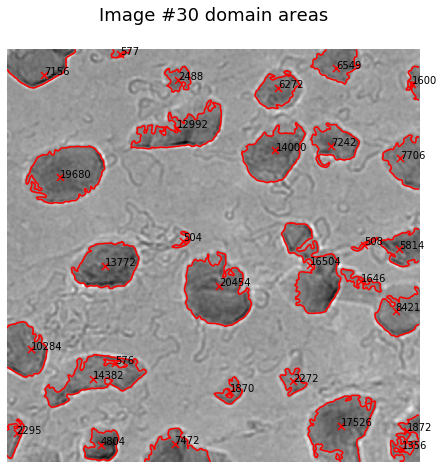

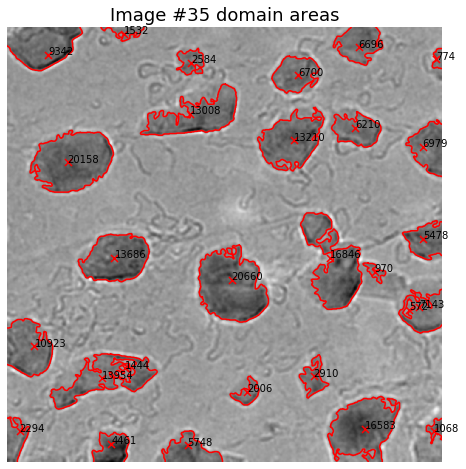

In [11]:
# loop over images in stack
for n in range(0, d['data'].shape[0], 5):

    # get image
    img = d['data'][n,:,:]
    # gaussian filter and rescale image
    filt = gaussian_filter(img, sigma=5)
    filt_s = rescale(filt, 0.5, mode="reflect")

    
    # get crystal domain information from image
    domains = mm.get_domains(filt_s, min_area=800, max_area=40000)

    plt.imshow(filt_s, cmap='gray', origin='lower')
    # loop over each domain and overlay it on image
    for i in range(len(domains['area'])):
        # plot contour line
        plt.plot(domains['contour'][i][:,0], domains['contour'][i][:,1], c='r', linewidth=1.5)
        # show area of domain
        plt.text(domains['mean_x'][i], domains['mean_y'][i], str(round(domains['area'][i])))
        plt.scatter(domains['mean_x'][i], domains['mean_y'][i], marker='x', c='r', s=50)
    mm.plot_setup(axes_on=False, title='Image #{} domain areas'.format(str(n)))
    plt.show()

### Create sliding window for image analysis

In [6]:
'''
# set size in pixels of sliding window to sample and oversample
samples = 15
oversamples = 50

# get index slices for sampled and oversampled windows
img = d['data'][0,:,:]
slices = mm.get_window_slices(img, samples, oversamples)
print('Created {} sampling windows across {} pixel image'.format(
    len(slices['s']), img.shape))
'''

"\n# set size in pixels of sliding window to sample and oversample\nsamples = 15\noversamples = 50\n\n# get index slices for sampled and oversampled windows\nimg = d['data'][0,:,:]\nslices = mm.get_window_slices(img, samples, oversamples)\nprint('Created {} sampling windows across {} pixel image'.format(\n    len(slices['s']), img.shape))\n"

### Apply sliding window for image analysis

In [7]:
'''
# loop over specified images in the image stack
for i in range(35, d['data'].shape[0], 12):
    
    # selet the image and normalize its intensity from 0 to 1
    img = d['data'][i, :, :]
    img = mm.norm_image(img)

    # create dictionary of calculated image layers to overlay on original image
    layers = mm.map_image(img, slices)
    
    # plot the raw image
    plt.imshow(img, origin='lower', cmap='gray')
    mm.plot_setup(title='Image #{}'.format(i), axes_on=False)
    plt.show()
    
    for lay in layers:
        plt.imshow(img, origin='lower', cmap='gray')
        plt.imshow( layers[lay], origin='lower', cmap='jet', alpha=0.2)
        mm.plot_setup(title='Image #{} {}'.format(i, lay), axes_on=False)
        plt.show()
'''

"\n# loop over specified images in the image stack\nfor i in range(35, d['data'].shape[0], 12):\n    \n    # selet the image and normalize its intensity from 0 to 1\n    img = d['data'][i, :, :]\n    img = mm.norm_image(img)\n\n    # create dictionary of calculated image layers to overlay on original image\n    layers = mm.map_image(img, slices)\n    \n    # plot the raw image\n    plt.imshow(img, origin='lower', cmap='gray')\n    mm.plot_setup(title='Image #{}'.format(i), axes_on=False)\n    plt.show()\n    \n    for lay in layers:\n        plt.imshow(img, origin='lower', cmap='gray')\n        plt.imshow( layers[lay], origin='lower', cmap='jet', alpha=0.2)\n        mm.plot_setup(title='Image #{} {}'.format(i, lay), axes_on=False)\n        plt.show()\n"

### Show image with masked domains

In [8]:
'''
masked_label = np.ma.masked_where(label > 10, label)

plt.imshow(filt_img, cmap='gray')
plt.imshow(masked_label, alpha=0.5, cmap='jet')
plt.show()
'''

"\nmasked_label = np.ma.masked_where(label > 10, label)\n\nplt.imshow(filt_img, cmap='gray')\nplt.imshow(masked_label, alpha=0.5, cmap='jet')\nplt.show()\n"

### Perform PCA for domain identification

In [9]:
'''
from sklearn.decomposition import PCA
# Make an instance of the Model

# plot original image
plt.imshow(img, origin='lower')
plt.show()


img0 = d['data'][0,:,:]
img1 = d['data'][21,:,:]
img2 = d['data'][-1,:,:]

imgs = [img0, img1, img2]


for idx, i in enumerate(imgs):
    
    # run PCA on 
    pca = PCA(n_components=0.6)
    pca.fit(mm.norm_image(i))
    components = pca.transform(mm.norm_image(i))
    projected = pca.inverse_transform(components)
    plt.title(str(idx))
    plt.imshow(projected, origin='lower')
    plt.show()
'''

"\nfrom sklearn.decomposition import PCA\n# Make an instance of the Model\n\n# plot original image\nplt.imshow(img, origin='lower')\nplt.show()\n\n\nimg0 = d['data'][0,:,:]\nimg1 = d['data'][21,:,:]\nimg2 = d['data'][-1,:,:]\n\nimgs = [img0, img1, img2]\n\n\nfor idx, i in enumerate(imgs):\n    \n    # run PCA on \n    pca = PCA(n_components=0.6)\n    pca.fit(mm.norm_image(i))\n    components = pca.transform(mm.norm_image(i))\n    projected = pca.inverse_transform(components)\n    plt.title(str(idx))\n    plt.imshow(projected, origin='lower')\n    plt.show()\n"